<a href="https://colab.research.google.com/github/Andywei24/DeepLearning/blob/Zoe%2Ftask2/ass1_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
import kagglehub
import torchvision.transforms as transforms


# add additonal imports here
class FashionDataset(Dataset):
    def __init__(self, csv_file, img_dir,column_class="articleTypeId", transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file with labels.
            img_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.df = pd.read_csv(csv_file)  # load CSV file
        self.img_dir = img_dir  # image folder path
        self.transform = transform  # image transformations
        self.targets = list(self.df[column_class].values)


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, f"{self.df.loc[idx,'imageId']}.jpg")  # Get image filename
        image = Image.open(img_name).convert("RGB")  # Load image

        if self.transform:
            image = self.transform(image)  # Apply transformations

        return image, self.targets[idx]

Download data with kagglehub

In [2]:
## For colab
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/ColabNotebooks/dataset"


Mounted at /content/drive


In [3]:
dataset_path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-small")
img_dir = os.path.join(dataset_path,"images")

The different datasets can be loaded using the class `FashionDataset` which is a custon PyTorch dataset (see [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) for more information). Below an example of how to use the `FashionDataset` constructor as well as some visualizations. Please note that you may have to adapt the arguments to match the strucucture of your working directory.

In [4]:
dataset = FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/train.csv",img_dir)

In [ ]:
dataset.df.head()

,imageId,articleTypeName,categoryName,articleTypeId,categoryId
0,35180,Backpacks,Bags,15,2
1,33585,Tshirts,Topwear,0,0
2,9464,Shirts,Topwear,1,0
3,8194,Shirts,Topwear,1,0
4,42231,Tops,Topwear,6,0


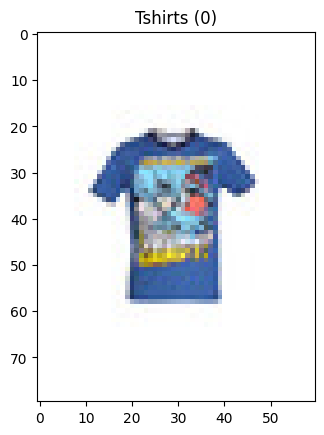

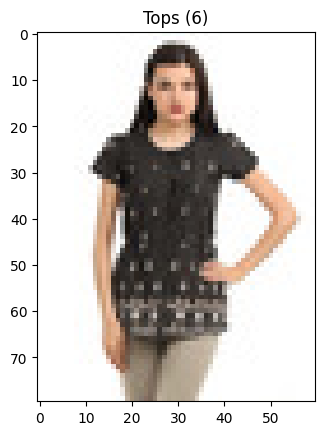

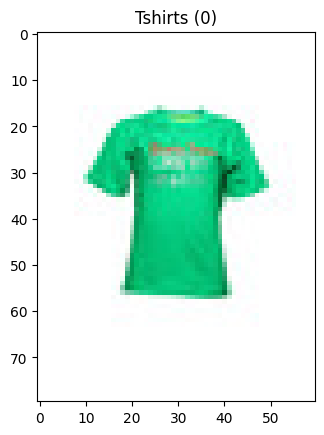

In [5]:
np.random.seed(42)
random_indices = np.random.choice(len(dataset),3)

for i in random_indices:
    img, label = dataset[i]
    plt.title(dataset.df.iloc[i]["articleTypeName"]+f" ({label.item()})")
    plt.imshow(img)
    plt.show()

## Loading different datasets

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# train_dataset = FashionDataset("dataset/train.csv",img_dir,transform=train_transform)
# main_test_dataset =  FashionDataset("dataset/main_test.csv",img_dir,transform=transform)
# new_test_dataset =  FashionDataset("dataset/new_test.csv",img_dir,transform=transform)
# main_support_dataset =  FashionDataset("dataset/main_support.csv",img_dir,transform=transform)
# new_support_dataset =  FashionDataset("dataset/new_support.csv",img_dir,transform=transform)
# merged_test_dataset =  FashionDataset("dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
# merged_support_dataset =  FashionDataset("dataset/merged_support.csv",img_dir,transform=transform)

# # datasets with categories
# main_test_dataset_cat =  FashionDataset("dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
# main_support_dataset_cat =  FashionDataset("dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)
train_dataset = FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/train.csv",img_dir,transform=transform)
main_test_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/main_test.csv",img_dir,transform=transform)
new_test_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/new_test.csv",img_dir,transform=transform)
main_support_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/main_support.csv",img_dir,transform=transform)
new_support_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/new_support.csv",img_dir,transform=transform)
merged_test_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/merged_test.csv",img_dir,transform=transform) # merged corresponds to main+new
merged_support_dataset =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/merged_support.csv",img_dir,transform=transform)

# datasets with categories
main_test_dataset_cat =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/main_test.csv",img_dir,column_class="categoryId",transform=transform)
main_support_dataset_cat =  FashionDataset("/content/drive/MyDrive/ColabNotebooks/dataset/main_support.csv",img_dir,column_class="categoryId",transform=transform)


label_id_to_label_name = {i: train_dataset.df[train_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39)}
label_id_to_label_name.update({i: new_test_dataset.df[new_test_dataset.df["articleTypeId"]==i]["articleTypeName"].iloc[0] for i in range(39,39+30)})

## Task 1

In [ ]:
# your solution
# train dataset: train_dataset
# test datset: main_test_dataset

In [8]:
# define network archietecture

class FashionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(FashionNet, self).__init__()

        # convolutional layers
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        # batch normalization layers
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.bn3 = torch.nn.BatchNorm2d(128)

        # pooling layer
        self.pool = torch.nn.MaxPool2d(2, 2)

        # dropout layer
        self.dropout = torch.nn.Dropout(0.25)

        # fully conneted layer
        self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)

        # activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # First convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolutional block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        # Third convolutional block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with dropout
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x



Training

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.amp import autocast, GradScaler

# hyperparameters
batch_size = 32
num_epochs = 10
learning_rate = 1e-4
weight_decay = 1e-4

# create data loader
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(main_test_dataset, batch_size = batch_size, shuffle = False)

num_classes = len(train_dataset.df['articleTypeId'].unique())

# initialize the model
model = FashionNet(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Improved training function with AMP
def train_model(model, train_loader, test_loader, device, epochs=10):
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3)

    # Initialize gradient scaler for AMP
    scaler = GradScaler()

    # Track best model
    best_test_acc = 0.0

    print(f"Starting training for {epochs} epochs...")

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]')

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            # Use AMP autocast
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale gradients and perform backward pass
            scaler.scale(loss).backward()

            # Update weights with scaled gradients
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            train_pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(train_correct/train_total):.4f}'
            })

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total

        # Test phase
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        test_pbar = tqdm(test_loader, desc=f'Epoch {epoch+1}/{epochs} [Test]')

        with torch.no_grad():
            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

                test_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{(test_correct/test_total):.4f}'
                })

        test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total

        # Update learning rate based on test accuracy
        scheduler.step(test_acc)

        # Print results
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

        # Clean GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Save best model
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            # Save the model if needed
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"New best test accuracy: {test_acc:.4f}")

    print(f"Training completed! Best test accuracy: {best_test_acc:.4f}")
    return model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
print(f"Using device: {device}")
model = train_model(model, train_loader, test_loader, device)

Using device: cuda
Starting training for 10 epochs...


Epoch 1/10 [Test]: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s, loss=1.2910, acc=0.7737]


Epoch 1/10:
Train Loss: 1.8087, Train Acc: 0.6236
Test Loss: 1.3335, Test Acc: 0.7737
New best test accuracy: 0.7737


Epoch 2/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.45it/s, loss=1.0892, acc=0.8132]


Epoch 2/10:
Train Loss: 1.4235, Train Acc: 0.7517
Test Loss: 1.2553, Test Acc: 0.8132
New best test accuracy: 0.8132


Epoch 3/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.97it/s, loss=1.1157, acc=0.8112]


Epoch 3/10:
Train Loss: 1.3314, Train Acc: 0.7833
Test Loss: 1.2142, Test Acc: 0.8112


Epoch 4/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.33it/s, loss=0.9163, acc=0.8312]


Epoch 4/10:
Train Loss: 1.2780, Train Acc: 0.8063
Test Loss: 1.1535, Test Acc: 0.8312
New best test accuracy: 0.8312


Epoch 5/10 [Test]: 100%|██████████| 63/63 [00:06<00:00, 10.36it/s, loss=0.8782, acc=0.8443]


Epoch 5/10:
Train Loss: 1.2377, Train Acc: 0.8199
Test Loss: 1.1178, Test Acc: 0.8443
New best test accuracy: 0.8443


Epoch 6/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.30it/s, loss=0.8846, acc=0.8438]


Epoch 6/10:
Train Loss: 1.2125, Train Acc: 0.8269
Test Loss: 1.1249, Test Acc: 0.8438


Epoch 7/10 [Test]: 100%|██████████| 63/63 [00:06<00:00, 10.37it/s, loss=0.8318, acc=0.8593]


Epoch 7/10:
Train Loss: 1.1913, Train Acc: 0.8341
Test Loss: 1.0736, Test Acc: 0.8593
New best test accuracy: 0.8593


Epoch 8/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.34it/s, loss=0.8653, acc=0.8683]


Epoch 8/10:
Train Loss: 1.1670, Train Acc: 0.8421
Test Loss: 1.0623, Test Acc: 0.8683
New best test accuracy: 0.8683


Epoch 9/10 [Test]: 100%|██████████| 63/63 [00:07<00:00,  8.48it/s, loss=0.8075, acc=0.8733]


Epoch 9/10:
Train Loss: 1.1533, Train Acc: 0.8499
Test Loss: 1.0540, Test Acc: 0.8733
New best test accuracy: 0.8733


Epoch 10/10 [Test]: 100%|██████████| 63/63 [00:06<00:00,  9.14it/s, loss=0.8314, acc=0.8723]

Epoch 10/10:
Train Loss: 1.1377, Train Acc: 0.8547
Test Loss: 1.0548, Test Acc: 0.8723
Training completed! Best test accuracy: 0.8733


In [ ]:
from sklearn.metrics import balanced_accuracy_score
def evaluate_model(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Regular accuracy
    accuracy = 100 * correct / total
    # Balanced accuracy
    balanced_acc = 100 * balanced_accuracy_score(all_labels, all_preds)

    return accuracy, balanced_acc

# After training your model
acc, bal_acc = evaluate_model(model, test_loader, device)
print(f'Accuracy: {acc:.2f}%')
print(f'Balanced Accuracy: {bal_acc:.2f}%')

Accuracy: 87.23%
Balanced Accuracy: 79.92%


## Task 2

In [ ]:
# your solution
# train dataset: train_dataset
# test and support dataset: see scenarios table

In [ ]:
import torch.nn.functional as F
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)

In [ ]:
class FashionNet(torch.nn.Module):
    def __init__(self, embedding_dim=256):
        super(FashionNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.embedding_dim = embedding_dim
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, embedding_dim)  # Now outputs a feature vector

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        embedding = self.fc2(x)  # Output feature vector
        return embedding


In [ ]:
def train_triplet_model(model, triplet_loader, device, epochs=10):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for anchor, positive, negative in tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            optimizer.zero_grad()

            emb_a = model(anchor)
            emb_p = model(positive)
            emb_n = model(negative)

            loss = criterion(emb_a, emb_p, emb_n)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(triplet_loader):.4f}")


In [ ]:
from torch.utils.data import Dataset
import random
from collections import defaultdict
class TripletFashionDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.labels = base_dataset.targets
        self.label_to_indices = self._build_index()

    def _build_index(self):
        label_to_indices = defaultdict(list)
        for idx, label in enumerate(self.labels):
            label_to_indices[label].append(idx)
        return label_to_indices

    def __getitem__(self, index):
        anchor_img, anchor_label = self.base_dataset[index]

        # Positive sample
        positive_index = index
        while positive_index == index:
            positive_index = random.choice(self.label_to_indices[anchor_label])
        positive_img, _ = self.base_dataset[positive_index]

        # Negative sample
        negative_label = anchor_label
        while negative_label == anchor_label:
            negative_label = random.choice(list(self.label_to_indices.keys()))
        negative_index = random.choice(self.label_to_indices[negative_label])
        negative_img, _ = self.base_dataset[negative_index]

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.base_dataset)

In [ ]:
# Use your existing dataset
triplet_dataset = TripletFashionDataset(train_dataset)
triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

# Train the model with triplet loss
train_triplet_model(model, triplet_loader, device, epochs=10)


Epoch 1/10:  17%|█▋        | 187/1123 [01:29<07:27,  2.09it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-45f515b37a19>", line 6, in <cell line: 0>
    train_triplet_model(model, triplet_loader, device, epochs=10)
  File "<ipython-input-17-c3ca677397c6>", line 10, in train_triplet_model
    for anchor, positive, negative in tqdm(triplet_loader, desc=f"Epoch {epoch+1}/{epochs}"):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 708, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 764, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

TypeError: object of type 'NoneType' has no len()

## Task 3

In [ ]:
# your solution
# test dataset: merged_test_dataset
# support/catalog dataset: support_test_dataset

## Task 4

In [ ]:
# your solution
# datasets: first 10 classes of train_dataset and main_test_dataset